In [92]:
import glob
import os

import pandas as pd

# Get list of all CSV files in the directory
list_of_files = glob.glob("../logs/performance/*.csv")

# Find the latest file
latest_file = max(list_of_files, key=os.path.getctime)

# Load the latest CSV file into a DataFrame
df_latest = pd.read_csv(latest_file)
# format: "timestamp", "category", "test_name","query", "scenario", "execution_time""cache_hits", "cache_misses", "cache_size","results_consistent",

print(df_latest)

# First check the unique category values to see what we're working with
print("Unique categories:", df_latest["category"].unique())

# Strip whitespace and normalize the category column
df_latest["category"] = df_latest["category"].str.strip()

               timestamp                 category  \
0    2025-02-21 17:07:36     base_keyword_queries   
1    2025-02-21 17:07:36     base_keyword_queries   
2    2025-02-21 17:07:36     base_keyword_queries   
3    2025-02-21 17:07:36     base_keyword_queries   
4    2025-02-21 17:07:36     base_keyword_queries   
..                   ...                      ...   
403  2025-02-21 17:08:22  percentile_combinations   
404  2025-02-21 17:08:22  percentile_combinations   
405  2025-02-21 17:08:22  percentile_combinations   
406  2025-02-21 17:08:22  percentile_combinations   
407  2025-02-21 17:08:22  percentile_combinations   

                         test_name  \
0                 simple_keyword_1   
1                 simple_keyword_1   
2                 simple_keyword_1   
3                 simple_keyword_1   
4                 simple_keyword_2   
..                             ...   
403  percentile_combination_AND_27   
404  percentile_combination_AND_28   
405  percentile_combi

In [93]:
# Filter the DataFrame by category with stripped values
base_keyword_queries = df_latest[df_latest["category"] == "base_keyword_queries"]
base_percentile_queries = df_latest[df_latest["category"] == "base_percentile_queries"]
keyword_combinations = df_latest[df_latest["category"] == "keyword_combinations"].reset_index()
percentile_combinations = df_latest[
    df_latest["category"] == "percentile_combinations"
].reset_index()

# Print to verify the filtering worked
print("\nCounts after fixing whitespace:")
print("Base keyword queries:", len(base_keyword_queries))
print("Base percentile queries:", len(base_percentile_queries))
print("Keyword combinations:", len(keyword_combinations))
print("Percentile combinations:", len(percentile_combinations))


Counts after fixing whitespace:
Base keyword queries: 44
Base percentile queries: 32
Keyword combinations: 220
Percentile combinations: 112


sequential
filtered
sequential_no_highlight
filtered_no_highlight


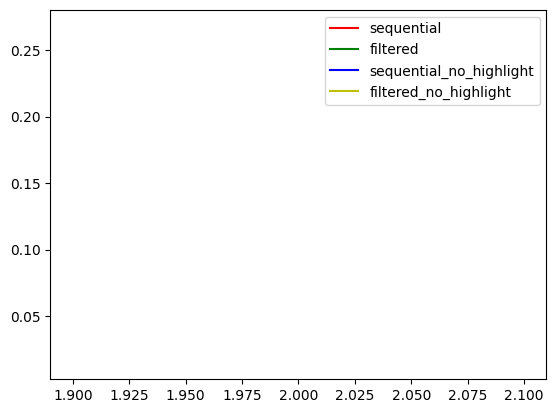

In [94]:
# plot the timings for the Keyword combinations with len(ids) on the x-axis and different colors for the different scenarios

import matplotlib.pyplot as plt

plt.figure()

# get the unique scenarios
scenarios = keyword_combinations["scenario"].unique()
colors = ["r", "g", "b", "y", "c", "m", "k"]
for i, scenario in enumerate(scenarios):
    print(scenario)
    df = keyword_combinations[keyword_combinations["scenario"] == scenario]

    mean_execution_time = df.groupby("num_terms")["execution_time"].mean()
    plt.plot(mean_execution_time.index, mean_execution_time, label=scenario, color=colors[i])

plt.legend()

sequential
filtered
sequential_no_highlight
filtered_no_highlight


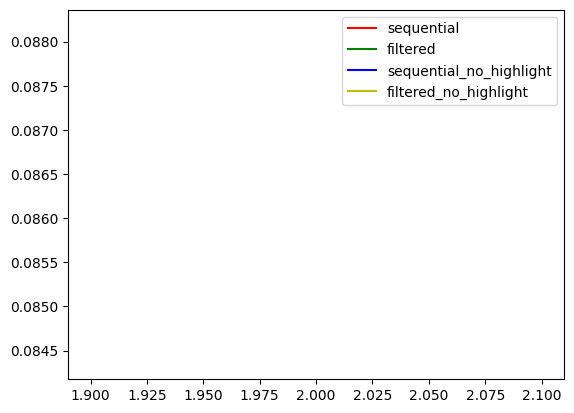

In [95]:
# plot the timing for the percentile combinations with len(ids) on the x-axis and different colors for the different scenarios

plt.figure()

# get the unique scenarios
scenarios = percentile_combinations["scenario"].unique()
colors = ["r", "g", "b", "y", "c", "m", "k"]

for i, scenario in enumerate(scenarios):
    print(scenario)
    df = percentile_combinations[percentile_combinations["scenario"] == scenario]

    mean_execution_time = df.groupby("num_terms")["execution_time"].mean()
    plt.plot(mean_execution_time.index, mean_execution_time, label=scenario, color=colors[i])

plt.legend()

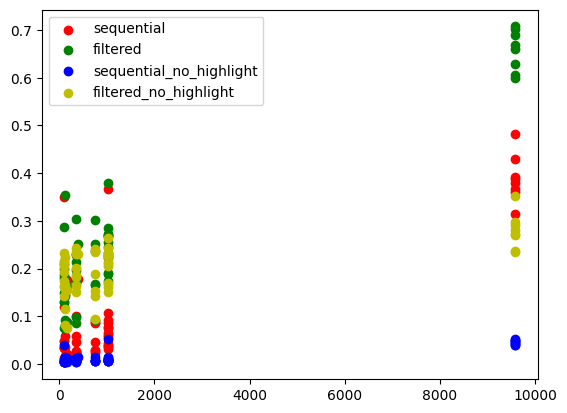

In [96]:
# plot the timing of the keyword queries with len(ids) == 2 to compare the different scenarios over the number of results in the first query (x-axis)


def find_results(id_str: str, df: pd.DataFrame) -> list[int]:
    return df[df["id_str"] == id_str]["results"].values[0]


plt.figure()

# get the unique scenarios
scenarios = base_keyword_queries["scenario"].unique()
colors = ["r", "g", "b", "y", "c", "m", "k"]

for i, scenario in enumerate(scenarios):
    df = keyword_combinations[keyword_combinations["scenario"] == scenario]
    scenario_base_keyword_queries = base_keyword_queries[
        base_keyword_queries["scenario"] == scenario
    ]
    df = df[df["num_terms"] == 2]

    df = df[df["results_consistent"] == True]

    df["first_query_id"] = df["ids"].apply(lambda x: eval(x)[0]["keyword_id"])
    df["first_query_results"] = df["first_query_id"].apply(
        lambda x: find_results(x, scenario_base_keyword_queries)
    )
    df["first_query_num_results"] = df["first_query_results"].apply(lambda x: len(x))

    plt.scatter(
        df["first_query_num_results"], df["execution_time"], label=scenario, color=colors[i]
    )

plt.legend()

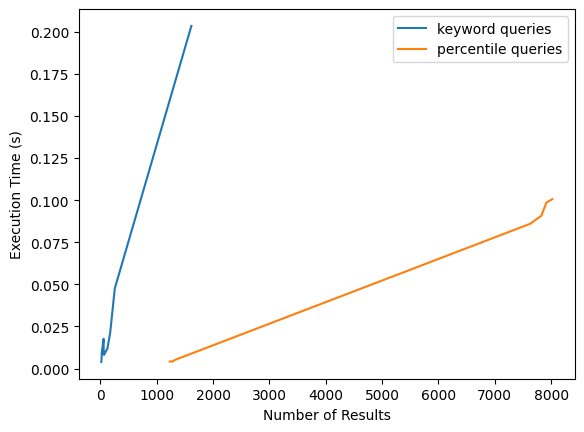

In [97]:
# compare kw vs pp time for base queries

# relevant columns: execution_time number_of_results (seneario is irrelevant for base queries)
plt.figure()

df = base_keyword_queries.groupby("num_results")["execution_time"].mean()

plt.plot(df.index, df, label="keyword queries")

df = base_percentile_queries.groupby("num_results")["execution_time"].mean()

plt.plot(df.index, df, label="percentile queries")

plt.xlabel("Number of Results")
plt.ylabel("Execution Time (s)")
plt.legend()

In [ ]:
# compare kw combinations internal and external ie: kw(a) AND kw(b) vs kw(a AND b)
# category: keyword_combinations and keyword_combinations_internal
# relevant columns: execution_time, num_terms, scenario for internal irrelevant for external relevant